In [4]:
!pip install torchaudio==0.7.0

In [66]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchvision
import numpy as np
from torchsummary import torchsummary
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import os
from glob import glob

In [6]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Get Librispeech dataset, and some noise 

In [7]:
# train_dataset = ta.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
train_dataset = ta.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [61]:
!curl -L -o noises.zip https://github.com/indrasweb/chvoice/raw/main/noises.zip
!unzip -q noises.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0   1254      0 --:--:-- --:--:-- --:--:--  1254
100 15.7M  100 15.7M    0     0  41.3M      0 --:--:-- --:--:-- --:--:-- 41.3M


## Signal Processing Utils

In [11]:
class DSP:

    def __init__(self, n_fft=254, hop_len=None):
        """ signal processing utils using torchaudio
        """
        self.n_fft = n_fft
        self.hop_len = n_fft//2 if hop_len is None else hop_len
        self.stft = ta.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=self.hop_len,
            win_length=n_fft,
            power=None
        )
        self.amplitude_to_db = ta.transforms.AmplitudeToDB()
        self.db_to_amplitude = lambda x: T.pow(T.pow(10.0, 0.1 * x), 1.)

    def sig_to_db_phase(self, sig):
        """ get dB and phase spectrograms of signal
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
        """
        # represent input signal in time-frequency domain
        stft = self.stft(sig)
        # magnitude = amount of power/volume for each phase = frequency
        mag, phase = ta.functional.magphase(stft)
        # put magnitudes on log scale
        db = self.amplitude_to_db(mag)

        return db, phase

    def db_phase_to_sig(self, db, phase):
        """ get wav signal from db and phase spectrograms.
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
                    ... do stuff to db ...
                >>> recovered_sig = chvoice.spec_to_sig(db, phase)
        """
        # go from log scale back to linear
        mag = self.db_to_amplitude(db)
        # recover full fourier transform of signal
        real = mag * T.cos(phase)
        imaginary = mag * T.sin(phase)
        complex = T.stack((real, imaginary), dim=-1)
        # inverse fourier transform to get signal
        sig = complex.istft(
            n_fft=self.n_fft,
            hop_length=self.hop_len
        )

        return sig

## Pre-processing and augmentation

In [71]:
class Noiser:

    def __init__(self, noise_dir, noise_lvl=0.4):
        """ add noise to signal, where noise is randomly 
            selected wav from noise_dir.
            noise_lvl = ratio of noise to signal (additive)
        """
        self.nsr = noise_lvl
        fns = glob(f'{noise_dir}/*/*.wav', recursive=True)
        rs = ta.transforms.Resample()
        self.noises = []
        for fn in fns:
            noise, sr = ta.load(fn)
            noise = ta.transforms.Resample(sr, 16000)(noise)
            self.noises.append(noise.squeeze(0))
        
    def add_noise(self, sig):
        """ sig is expected to be one-dimensional (N,)
            snr = maximum signal to noise ratio 
        """
        # stochastic amount of noise
        noise_lvl = np.random.random() * self.nsr

        # 10% of the time just add white noise
        if np.random.random() > 0.9:
            white_noise = T.normal(
                mean=0., 
                std=0.025, size=sig.shape
            )
            return sig + white_noise*self.nsr

        # otherwise add a noise from the archive
        noise = random.choice(self.noises)
        if len(noise) < len(sig):
            n_repeats = int(np.ceil(len(sig) / len(noise)))
            noise = T.repeat_interleave(noise, n_repeats)
        
        return sig + noise[:len(sig)]*self.nsr

In [80]:
denormalize = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=0., std=1/18),
    torchvision.transforms.Normalize(mean=32., std=1.)
])

normalize = torchvision.transforms.Normalize(mean=-32., std=18)

def preprocess(X, dsp, noiser):
    clean = []
    noisy = []
    wavs = [d[0] for d in X]

    for wav in wavs:

        db, phase = dsp.sig_to_db_phase(wav)
        if db.size(2) < 128:
            continue

        # make clean chunks of audio
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        clean.append(chunks)

        # make corresponding noisy chunks of audio
        aug_wav = noiser.add_noise(wav.squeeze(0))
        db, phase = dsp.sig_to_db_phase(aug_wav.unsqueeze(0))
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        noisy.append(chunks)

    clean = T.vstack(clean).unsqueeze(1)
    noisy = T.vstack(noisy).unsqueeze(1)
    
    return clean, noisy

## Model Definition (UNet)

In [81]:
### CREDIT : https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = T.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [82]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [85]:
dsp = DSP(254)
noiser = Noiser('noises/', noise_lvl=0.4)

train_loader = T.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

model = UNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()

In [86]:
for epoch in range(1, 11):
    print(f'----- EPOCH {epoch} -----')
    for i, (clean, noisy) in enumerate(train_loader):
        clean = clean[:40,:,:,:].to(DEVICE)
        noisy = noisy[:40,:,:,:].to(DEVICE)
        optim.zero_grad()
        pred = model(noisy)
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        print(i, loss.item())

----- EPOCH 1 -----
0 0.5749878883361816
1 0.4696008861064911
2 0.348304808139801
3 0.19971202313899994
4 0.2680077850818634
5 0.4275439381599426
6 0.21812279522418976
7 0.1450863927602768
8 0.15048108994960785
9 0.16666361689567566
10 0.15927231311798096
11 0.13871191442012787
12 0.19304589927196503
13 0.09571107476949692
14 0.11561568826436996
15 0.08528027683496475
16 0.14270931482315063
17 0.08404075354337692
18 0.08064096421003342
19 0.1364779770374298
20 0.1107763797044754
21 0.09252841770648956
22 0.06328979134559631
23 0.09107840061187744
24 0.1279935985803604
25 0.07434338331222534
26 0.05096698924899101
27 0.10024397820234299
28 0.11653698980808258
29 0.09767293184995651
30 0.3860187530517578
31 0.11090337485074997
32 0.08066896349191666
33 0.1024172306060791
34 0.060497500002384186
35 0.08645587414503098
36 0.12166409939527512
37 0.08283897489309311
38 0.12552177906036377
39 0.09588818997144699
40 0.5036905407905579
41 0.10773017257452011
42 0.1321333944797516
43 0.404222339

KeyboardInterrupt: ignored

# Evaluate

In [87]:
def evaluate(wav, model, plot_spectrograms=True):
        
    db, phase = dsp.sig_to_db_phase(wav)

    if plot_spectrograms:
        print('dB spectrogram in')
        plt.imshow(db[0])
        plt.show()

    assert db.size(2) >= 128, 'wav too small'

    chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
    chunks = normalize(chunks).unsqueeze(1).to(DEVICE)
                 
    with T.no_grad():
        proc = denormalize(model(chunks))
    
    db_out = T.cat([c for c in proc.squeeze(1)], dim=1).cpu()
    
    if plot_spectrograms:
        print('db spectrogram out')
        plt.imshow(db_out.numpy())
        plt.show()
    
    phase_clipped = phase[0,:,:db_out.size(1)]
    sig = dsp.db_phase_to_sig(db_out, phase_clipped)
    
    return sig

Load a sample, and add noise to it

In [89]:
in_sig = train_dataset[40][0]
Audio(in_sig, rate=16000)

In [93]:
wobbly = noiser.add_noise(in_sig.squeeze(0)).unsqueeze(0)
Audio(wobbly, rate=16000)

dB spectrogram in


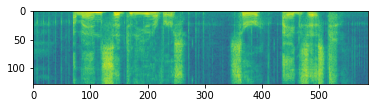

db spectrogram out


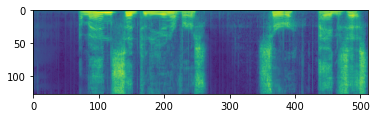

In [94]:
model = model.eval()
out_sig = evaluate(wobbly, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)